<a href="https://colab.research.google.com/github/Jefffish09/MachineLearning/blob/dev/Classification/binary/bert_binary_tf2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

References:

* https://www.tensorflow.org/tutorials/text/classify_text_with_bert


In [1]:
!pip install -U -q tensorflow-text
!pip install -U -q tf-models-official

     |████████████████████████████████| 3.4MB 18.6MB/s 
     |████████████████████████████████| 1.1MB 18.4MB/s 
     |████████████████████████████████| 37.6MB 85kB/s 
     |████████████████████████████████| 51kB 9.4MB/s 
     |████████████████████████████████| 358kB 55.3MB/s 
     |████████████████████████████████| 1.2MB 50.0MB/s 
     |████████████████████████████████| 645kB 55.9MB/s 
     |████████████████████████████████| 706kB 50.9MB/s 
     |████████████████████████████████| 174kB 61.5MB/s 
     |████████████████████████████████| 102kB 15.1MB/s 


In [2]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.utils import get_file, plot_model
from tensorflow.keras.preprocessing import text_dataset_from_directory
from tensorflow.keras.layers import Dropout, Dense
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.data.experimental import cardinality
from tensorflow_hub import KerasLayer
import tensorflow_text
from official.nlp import optimization  # to create AdamW optmizer
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import StratifiedKFold


In [3]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 2021
epochs = 100
lr = 3e-5
earlystopping_patience = 3

In [4]:
# Download the IMDB dataset

url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
dataset = get_file("aclImdb_v1.tar.gz", url, untar=True, cache_dir=".", cache_subdir="")

dataset_dir = os.path.join(os.path.dirname(dataset), "aclImdb")
train_dir = os.path.join(dataset_dir, "train")

# remove unused folders to make it easier to load the data
remove_dir = os.path.join(train_dir, "unsup")
shutil.rmtree(remove_dir)

# Training dataset
raw_train_ds = text_dataset_from_directory(
    "aclImdb/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset="training",
    seed=seed)
class_names = raw_train_ds.class_names
print("Class names: {}".format(class_names))
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Validation dataset
val_ds = text_dataset_from_directory(
    "aclImdb/train",
    batch_size=batch_size,
    validation_split=0.2,
    subset="validation",
    seed=seed)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Tesing dataset
test_ds = text_dataset_from_directory(
    "aclImdb/test",
    batch_size=batch_size)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

84131840/84125825 [==============================] - 3s 0us/step
Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Class names: ['neg', 'pos']
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


In [5]:
# Choose a BERT model to fine-tune

map_name_to_handle = {
    "bert_en_uncased_L-12_H-768_A-12":
        "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3",
    "bert_en_cased_L-12_H-768_A-12":
        "https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3",
    "bert_multi_cased_L-12_H-768_A-12":
        "https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3",
    "small_bert/bert_en_uncased_L-2_H-128_A-2":
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1",
    "small_bert/bert_en_uncased_L-2_H-256_A-4":
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1",
    "small_bert/bert_en_uncased_L-2_H-512_A-8":
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1",
    "small_bert/bert_en_uncased_L-2_H-768_A-12":
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1",
    "small_bert/bert_en_uncased_L-4_H-128_A-2":
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1",
    "small_bert/bert_en_uncased_L-4_H-256_A-4":
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1",
    "small_bert/bert_en_uncased_L-4_H-512_A-8":
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1",
    "small_bert/bert_en_uncased_L-4_H-768_A-12":
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1",
    "small_bert/bert_en_uncased_L-6_H-128_A-2":
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1",
    "small_bert/bert_en_uncased_L-6_H-256_A-4":
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1",
    "small_bert/bert_en_uncased_L-6_H-512_A-8":
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1",
    "small_bert/bert_en_uncased_L-6_H-768_A-12":
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1",
    "small_bert/bert_en_uncased_L-8_H-128_A-2":
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1",
    "small_bert/bert_en_uncased_L-8_H-256_A-4":
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1",
    "small_bert/bert_en_uncased_L-8_H-512_A-8":
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1",
    "small_bert/bert_en_uncased_L-8_H-768_A-12":
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1",
    "small_bert/bert_en_uncased_L-10_H-128_A-2":
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1",
    "small_bert/bert_en_uncased_L-10_H-256_A-4":
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1",
    "small_bert/bert_en_uncased_L-10_H-512_A-8":
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1",
    "small_bert/bert_en_uncased_L-10_H-768_A-12":
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1",
    "small_bert/bert_en_uncased_L-12_H-128_A-2":
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1",
    "small_bert/bert_en_uncased_L-12_H-256_A-4":
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1",
    "small_bert/bert_en_uncased_L-12_H-512_A-8":
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1",
    "small_bert/bert_en_uncased_L-12_H-768_A-12":
        "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1",
    "albert_en_base":
        "https://tfhub.dev/tensorflow/albert_en_base/2",
    "electra_small":
        "https://tfhub.dev/google/electra_small/2",
    "electra_base":
        "https://tfhub.dev/google/electra_base/2",
    "experts_pubmed":
        "https://tfhub.dev/google/experts/bert/pubmed/2",
    "experts_wiki_books":
        "https://tfhub.dev/google/experts/bert/wiki_books/2",
    "talking-heads_base":
        "https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1",
}

map_model_to_preprocess = {
    "bert_en_uncased_L-12_H-768_A-12":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "bert_en_cased_L-12_H-768_A-12":
        "https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3",
    "small_bert/bert_en_uncased_L-2_H-128_A-2":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "small_bert/bert_en_uncased_L-2_H-256_A-4":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "small_bert/bert_en_uncased_L-2_H-512_A-8":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "small_bert/bert_en_uncased_L-2_H-768_A-12":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "small_bert/bert_en_uncased_L-4_H-128_A-2":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "small_bert/bert_en_uncased_L-4_H-256_A-4":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "small_bert/bert_en_uncased_L-4_H-512_A-8":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "small_bert/bert_en_uncased_L-4_H-768_A-12":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "small_bert/bert_en_uncased_L-6_H-128_A-2":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "small_bert/bert_en_uncased_L-6_H-256_A-4":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "small_bert/bert_en_uncased_L-6_H-512_A-8":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "small_bert/bert_en_uncased_L-6_H-768_A-12":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "small_bert/bert_en_uncased_L-8_H-128_A-2":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "small_bert/bert_en_uncased_L-8_H-256_A-4":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "small_bert/bert_en_uncased_L-8_H-512_A-8":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "small_bert/bert_en_uncased_L-8_H-768_A-12":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "small_bert/bert_en_uncased_L-10_H-128_A-2":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "small_bert/bert_en_uncased_L-10_H-256_A-4":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "small_bert/bert_en_uncased_L-10_H-512_A-8":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "small_bert/bert_en_uncased_L-10_H-768_A-12":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "small_bert/bert_en_uncased_L-12_H-128_A-2":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "small_bert/bert_en_uncased_L-12_H-256_A-4":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "small_bert/bert_en_uncased_L-12_H-512_A-8":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "small_bert/bert_en_uncased_L-12_H-768_A-12":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "bert_multi_cased_L-12_H-768_A-12":
        "https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3",
    "albert_en_base":
        "https://tfhub.dev/tensorflow/albert_en_preprocess/2",
    "electra_small":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "electra_base":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "experts_pubmed":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "experts_wiki_books":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
    "talking-heads_base":
        "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3",
}

bert_model_name = "small_bert/bert_en_uncased_L-4_H-512_A-8" 
tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f"BERT model selected: {tfhub_handle_encoder}")
print(f"Preprocess model auto-selected: {tfhub_handle_preprocess}")

BERT model selected: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [6]:
def plot_perf(history):
  # Create a plot of accuracy and loss over time
  history_dict = history.history
  history_dict.keys()

  acc = history_dict["binary_accuracy"]
  val_acc = history_dict["val_binary_accuracy"]
  loss = history_dict["loss"]
  val_loss = history_dict["val_loss"]

  epochs = range(1, len(acc) + 1)

  # Training and validation loss
  plt.plot(epochs, loss, "r", label="Training loss")
  # b is for "solid blue line"
  plt.plot(epochs, val_loss, "b", label="Validation loss")
  plt.title("Training and validation loss")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()

  # Training and validation accuracy
  plt.plot(epochs, acc, "r", label="Training acc")
  plt.plot(epochs, val_acc, "b", label="Validation acc")
  plt.title("Training and validation accuracy")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend(loc="lower right")
  plt.show()

KFold: 1 starts.
Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/100
563/563 [==============================] - 151s 254ms/step - loss: 0.6811 - binary_accuracy: 0.5743 - val_loss: 0.5148 - val_binary_accuracy: 0.7182
Epoch 2/100
563/563 [==============================] - 144s 255ms/step - loss: 0.4888 - binary_accuracy: 0.7503 - val_loss: 0.4292 - val_binary_accuracy: 0.7996
Epoch 3/100
563/563 [==============================] - 142s 253ms/step - loss: 0.4061 - binary_accuracy: 0.8102 - val_loss: 0.4090 - val_binary_accuracy: 0.8200
Epoch 4/100
563/563 [==============================] - 141s 250ms/step - loss: 0.3451 - binary_accuracy: 0.8427 - val_loss: 0.3838 - val_binary_accuracy: 0.8222
Epoch 5/100
563/563 [==============================] - 140s 249ms/step - loss: 0.3020 - binary_accuracy: 0.8697 - val_loss: 0.3935 - val_binary_accuracy: 0.8382
Epoch 6/100
563/563 [==============================] - 142s 252ms/step - loss: 0.2501 

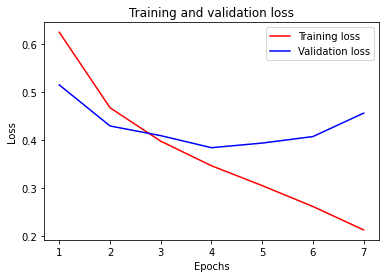

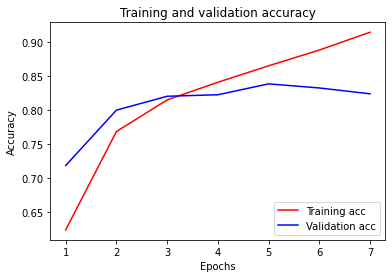

              precision    recall  f1-score   support

           0      0.793     0.901     0.844     12500
           1      0.885     0.765     0.821     12500

    accuracy                          0.833     25000
   macro avg      0.839     0.833     0.832     25000
weighted avg      0.839     0.833     0.832     25000


KFold: 2 starts.
Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/100
563/563 [==============================] - 147s 251ms/step - loss: 0.7198 - binary_accuracy: 0.5164 - val_loss: 0.5609 - val_binary_accuracy: 0.6708
Epoch 2/100
563/563 [==============================] - 141s 250ms/step - loss: 0.5211 - binary_accuracy: 0.7257 - val_loss: 0.4375 - val_binary_accuracy: 0.7980
Epoch 3/100
563/563 [==============================] - 140s 249ms/step - loss: 0.4080 - binary_accuracy: 0.8070 - val_loss: 0.3983 - val_binary_accuracy: 0.8200
Epoch 4/100
563/563 [==============================] - 139s 248ms/step - loss: 0

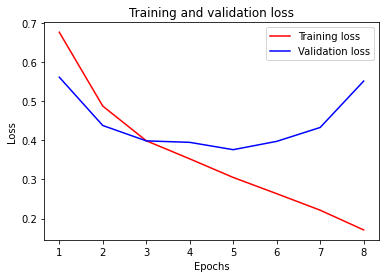

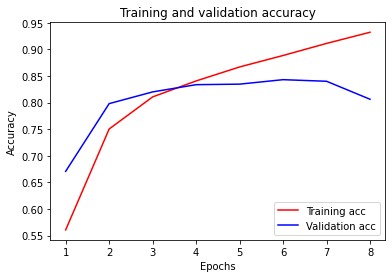

              precision    recall  f1-score   support

           0      0.810     0.894     0.850     12500
           1      0.882     0.790     0.833     12500

    accuracy                          0.842     25000
   macro avg      0.846     0.842     0.842     25000
weighted avg      0.846     0.842     0.842     25000


KFold: 3 starts.


Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/100
563/563 [==============================] - 146s 251ms/step - loss: 0.7444 - binary_accuracy: 0.5050 - val_loss: 0.5638 - val_binary_accuracy: 0.6792
Epoch 2/100
563/563 [==============================] - 142s 252ms/step - loss: 0.5302 - binary_accuracy: 0.7146 - val_loss: 0.4384 - val_binary_accuracy: 0.7968
Epoch 3/100
563/563 [==============================] - 142s 252ms/step - loss: 0.4075 - binary_accuracy: 0.8085 - val_loss: 0.4155 - val_binary_accuracy: 0.8222
Epoch 4/100
563/563 [==============================] - 142s 251ms/step - loss: 0.3538 - binary_accuracy: 0.8412 - val_loss: 0.3957 - val_binary_accuracy: 0.8316
Epoch 5/100
563/563 [==============================] - 142s 252ms/step - loss: 0.3062 - binary_accuracy: 0.8615 - val_loss: 0.3958 - val_binary_accuracy: 0.8274
Epoch 6/100
563/563 [==============================] - 141s 250ms/step - loss: 0.2544 - binary_accuracy

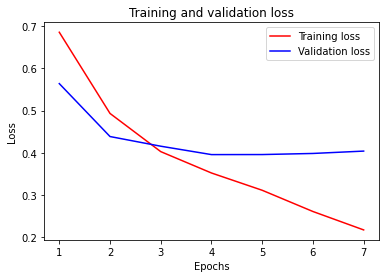

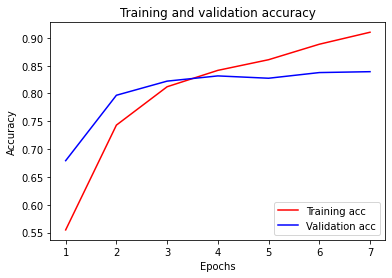

              precision    recall  f1-score   support

           0      0.816     0.874     0.844     12500
           1      0.864     0.803     0.832     12500

    accuracy                          0.838     25000
   macro avg      0.840     0.838     0.838     25000
weighted avg      0.840     0.838     0.838     25000


KFold: 4 starts.


Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/100
563/563 [==============================] - 148s 254ms/step - loss: 0.6964 - binary_accuracy: 0.5287 - val_loss: 0.5341 - val_binary_accuracy: 0.7208
Epoch 2/100
563/563 [==============================] - 143s 254ms/step - loss: 0.5016 - binary_accuracy: 0.7368 - val_loss: 0.4272 - val_binary_accuracy: 0.7902
Epoch 3/100
563/563 [==============================] - 142s 253ms/step - loss: 0.3948 - binary_accuracy: 0.8090 - val_loss: 0.4041 - val_binary_accuracy: 0.8184
Epoch 4/100
563/563 [==============================] - 141s 251ms/step - loss: 0.3528 - binary_accuracy: 0.8348 - val_loss: 0.3842 - val_binary_accuracy: 0.8296
Epoch 5/100
563/563 [==============================] - 143s 255ms/step - loss: 0.3042 - binary_accuracy: 0.8644 - val_loss: 0.3866 - val_binary_accuracy: 0.8342
Epoch 6/100
563/563 [==============================] - 144s 255ms/step - loss: 0.2557 - binary_accuracy

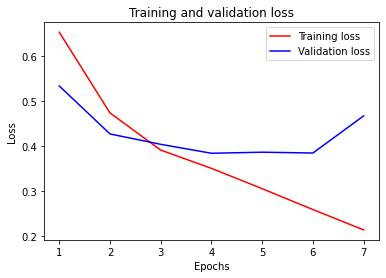

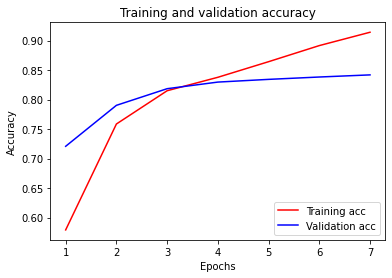

              precision    recall  f1-score   support

           0      0.827     0.862     0.844     12500
           1      0.856     0.820     0.838     12500

    accuracy                          0.841     25000
   macro avg      0.842     0.841     0.841     25000
weighted avg      0.842     0.841     0.841     25000


KFold: 5 starts.


Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/100
563/563 [==============================] - 150s 255ms/step - loss: 0.7119 - binary_accuracy: 0.5168 - val_loss: 0.5581 - val_binary_accuracy: 0.6774
Epoch 2/100
563/563 [==============================] - 140s 248ms/step - loss: 0.5266 - binary_accuracy: 0.7129 - val_loss: 0.4313 - val_binary_accuracy: 0.7840
Epoch 3/100
563/563 [==============================] - 140s 249ms/step - loss: 0.4106 - binary_accuracy: 0.8005 - val_loss: 0.3996 - val_binary_accuracy: 0.8150
Epoch 4/100
563/563 [==============================] - 140s 249ms/step - loss: 0.3538 - binary_accuracy: 0.8382 - val_loss: 0.3840 - val_binary_accuracy: 0.8314
Epoch 5/100
563/563 [==============================] - 138s 246ms/step - loss: 0.3111 - binary_accuracy: 0.8624 - val_loss: 0.3902 - val_binary_accuracy: 0.8378
Epoch 6/100
563/563 [==============================] - 139s 246ms/step - loss: 0.2596 - binary_accuracy

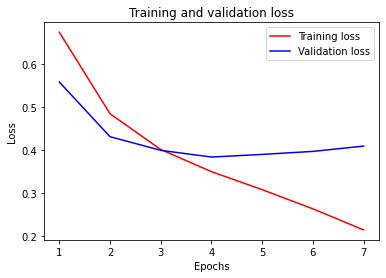

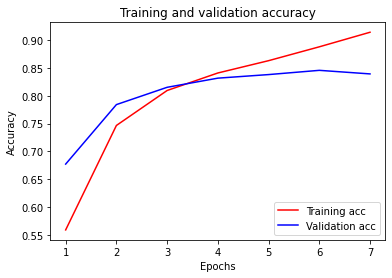

              precision    recall  f1-score   support

           0      0.817     0.880     0.848     12500
           1      0.870     0.803     0.835     12500

    accuracy                          0.842     25000
   macro avg      0.844     0.842     0.841     25000
weighted avg      0.844     0.842     0.841     25000


KFold: 6 starts.


Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/100
563/563 [==============================] - 144s 246ms/step - loss: 0.7177 - binary_accuracy: 0.5249 - val_loss: 0.5504 - val_binary_accuracy: 0.6794
Epoch 2/100
563/563 [==============================] - 139s 247ms/step - loss: 0.5254 - binary_accuracy: 0.7187 - val_loss: 0.4381 - val_binary_accuracy: 0.7924
Epoch 3/100
563/563 [==============================] - 138s 246ms/step - loss: 0.4159 - binary_accuracy: 0.8024 - val_loss: 0.4091 - val_binary_accuracy: 0.8094
Epoch 4/100
563/563 [==============================] - 139s 247ms/step - loss: 0.3504 - binary_accuracy: 0.8401 - val_loss: 0.3870 - val_binary_accuracy: 0.8158
Epoch 5/100
563/563 [==============================] - 139s 247ms/step - loss: 0.3163 - binary_accuracy: 0.8609 - val_loss: 0.3886 - val_binary_accuracy: 0.8366
Epoch 6/100
563/563 [==============================] - 139s 247ms/step - loss: 0.2649 - binary_accuracy

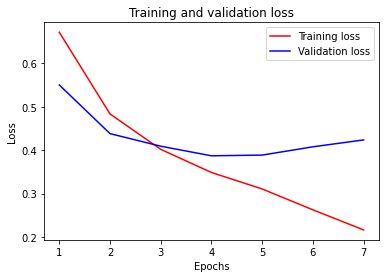

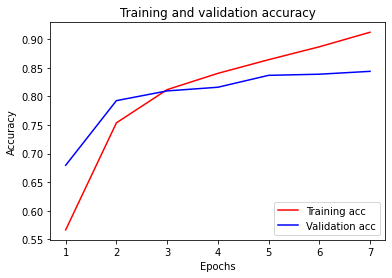

              precision    recall  f1-score   support

           0      0.784     0.904     0.840     12500
           1      0.887     0.751     0.813     12500

    accuracy                          0.827     25000
   macro avg      0.835     0.827     0.826     25000
weighted avg      0.835     0.827     0.826     25000


KFold: 7 starts.


Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/100
563/563 [==============================] - 144s 247ms/step - loss: 0.7201 - binary_accuracy: 0.5105 - val_loss: 0.5681 - val_binary_accuracy: 0.6584
Epoch 2/100
563/563 [==============================] - 139s 247ms/step - loss: 0.5357 - binary_accuracy: 0.7071 - val_loss: 0.4299 - val_binary_accuracy: 0.7962
Epoch 3/100
563/563 [==============================] - 139s 247ms/step - loss: 0.4122 - binary_accuracy: 0.8033 - val_loss: 0.4089 - val_binary_accuracy: 0.8198
Epoch 4/100
563/563 [==============================] - 139s 246ms/step - loss: 0.3445 - binary_accuracy: 0.8418 - val_loss: 0.3816 - val_binary_accuracy: 0.8314
Epoch 5/100
563/563 [==============================] - 139s 247ms/step - loss: 0.3118 - binary_accuracy: 0.8635 - val_loss: 0.3850 - val_binary_accuracy: 0.8412
Epoch 6/100
563/563 [==============================] - 139s 247ms/step - loss: 0.2568 - binary_accuracy

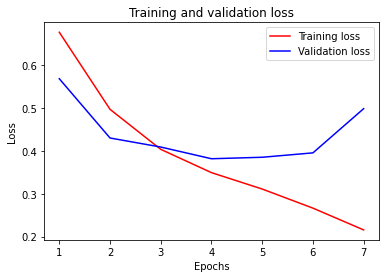

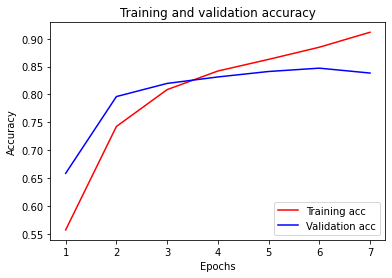

              precision    recall  f1-score   support

           0      0.804     0.890     0.845     12500
           1      0.877     0.783     0.827     12500

    accuracy                          0.837     25000
   macro avg      0.841     0.837     0.836     25000
weighted avg      0.841     0.837     0.836     25000


KFold: 8 starts.


Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/100
563/563 [==============================] - 145s 248ms/step - loss: 0.7211 - binary_accuracy: 0.5321 - val_loss: 0.5536 - val_binary_accuracy: 0.6890
Epoch 2/100
563/563 [==============================] - 139s 247ms/step - loss: 0.5242 - binary_accuracy: 0.7234 - val_loss: 0.4299 - val_binary_accuracy: 0.7958
Epoch 3/100
563/563 [==============================] - 140s 248ms/step - loss: 0.3978 - binary_accuracy: 0.8094 - val_loss: 0.4037 - val_binary_accuracy: 0.8150
Epoch 4/100
563/563 [==============================] - 139s 247ms/step - loss: 0.3569 - binary_accuracy: 0.8370 - val_loss: 0.4090 - val_binary_accuracy: 0.8296
Epoch 5/100
563/563 [==============================] - 139s 247ms/step - loss: 0.3075 - binary_accuracy: 0.8661 - val_loss: 0.3942 - val_binary_accuracy: 0.8234
Epoch 6/100
563/563 [==============================] - 140s 248ms/step - loss: 0.2658 - binary_accuracy

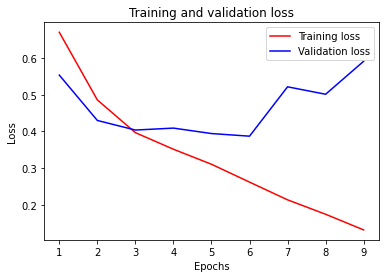

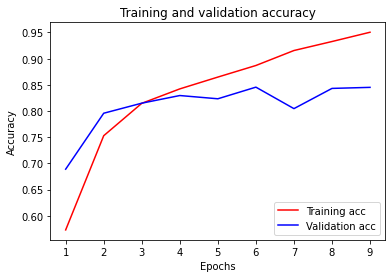

              precision    recall  f1-score   support

           0      0.831     0.879     0.854     12500
           1      0.872     0.821     0.846     12500

    accuracy                          0.850     25000
   macro avg      0.851     0.850     0.850     25000
weighted avg      0.851     0.850     0.850     25000


KFold: 9 starts.


Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/100
563/563 [==============================] - 145s 248ms/step - loss: 0.7743 - binary_accuracy: 0.5391 - val_loss: 0.5279 - val_binary_accuracy: 0.7056
Epoch 2/100
563/563 [==============================] - 139s 247ms/step - loss: 0.5031 - binary_accuracy: 0.7443 - val_loss: 0.4350 - val_binary_accuracy: 0.7850
Epoch 3/100
563/563 [==============================] - 140s 248ms/step - loss: 0.4098 - binary_accuracy: 0.8025 - val_loss: 0.4068 - val_binary_accuracy: 0.8096
Epoch 4/100
563/563 [==============================] - 140s 249ms/step - loss: 0.3608 - binary_accuracy: 0.8364 - val_loss: 0.3847 - val_binary_accuracy: 0.8274
Epoch 5/100
563/563 [==============================] - 139s 247ms/step - loss: 0.3147 - binary_accuracy: 0.8647 - val_loss: 0.3766 - val_binary_accuracy: 0.8422
Epoch 6/100
563/563 [==============================] - 139s 247ms/step - loss: 0.2628 - binary_accuracy

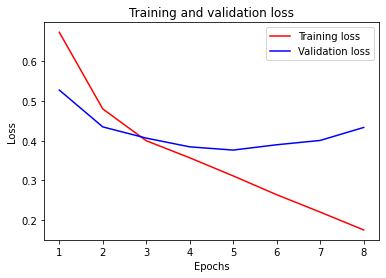

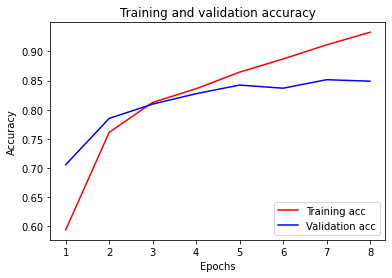

              precision    recall  f1-score   support

           0      0.832     0.871     0.851     12500
           1      0.865     0.824     0.844     12500

    accuracy                          0.847     25000
   macro avg      0.848     0.847     0.847     25000
weighted avg      0.848     0.847     0.847     25000


KFold: 10 starts.


Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/100
563/563 [==============================] - 145s 247ms/step - loss: 0.7057 - binary_accuracy: 0.5413 - val_loss: 0.5245 - val_binary_accuracy: 0.7144
Epoch 2/100
563/563 [==============================] - 139s 248ms/step - loss: 0.4974 - binary_accuracy: 0.7428 - val_loss: 0.4263 - val_binary_accuracy: 0.7904
Epoch 3/100
563/563 [==============================] - 139s 247ms/step - loss: 0.4042 - binary_accuracy: 0.8054 - val_loss: 0.4186 - val_binary_accuracy: 0.8224
Epoch 4/100
563/563 [==============================] - 140s 248ms/step - loss: 0.3466 - binary_accuracy: 0.8409 - val_loss: 0.3803 - val_binary_accuracy: 0.8302
Epoch 5/100
563/563 [==============================] - 140s 248ms/step - loss: 0.2989 - binary_accuracy: 0.8695 - val_loss: 0.3691 - val_binary_accuracy: 0.8354
Epoch 6/100
563/563 [==============================] - 140s 248ms/step - loss: 0.2602 - binary_accuracy

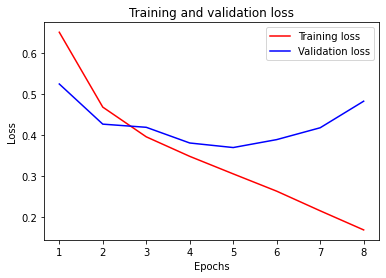

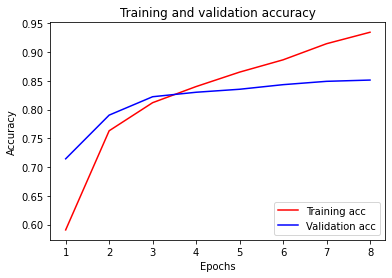

              precision    recall  f1-score   support

           0      0.828     0.876     0.851     12500
           1      0.869     0.817     0.842     12500

    accuracy                          0.847     25000
   macro avg      0.848     0.847     0.847     25000
weighted avg      0.848     0.847     0.847     25000


Average accuracy: 0.8404 (+/- 0.0066)
Average loss: 0.3591 (+/- 0.0052)
Average F1: 0.8331 (+/- 0.0098)


In [7]:
# Create and train the model

earlystop_callback = EarlyStopping(
  monitor="val_loss",
  min_delta=0.0001,
  patience=earlystopping_patience,
  restore_best_weights=True)

kfold = StratifiedKFold(n_splits=10, random_state=seed, shuffle=True)
model = None
cv_acc = []
cv_loss = []
cv_f1 = []

x_train = np.concatenate([x for x, y in train_ds], axis=0)
y_train = np.concatenate([y for x, y in train_ds], axis=0)

for n, (train, valid) in enumerate(kfold.split(x_train, y_train)):

  print("KFold: {} starts.".format(n + 1))
  del model
  tf.keras.backend.clear_session()

  text_input = Input(shape=(), dtype=tf.string, name="text")
  preprocessing_layer = KerasLayer(handle=tfhub_handle_preprocess, name="preprocessing")
  encoder_inputs = preprocessing_layer(text_input)
  encoder = KerasLayer(handle=tfhub_handle_encoder, trainable=True, name="BERT_encoder")
  outputs = encoder(encoder_inputs)
  net = outputs["pooled_output"]
  net = Dropout(rate=0.1)(net)
  net = Dense(units=1, activation=None, name="classifier")(net)
  model = Model(inputs=text_input, outputs=net)
  # plot_model(model)

  steps_per_epoch = cardinality(train_ds).numpy()
  num_train_steps = steps_per_epoch * epochs
  num_warmup_steps = int(0.1 * num_train_steps)

  optimizer = optimization.create_optimizer(init_lr=lr,
                                            num_train_steps=num_train_steps,
                                            num_warmup_steps=num_warmup_steps,
                                            optimizer_type="adamw")

  model.compile(
      optimizer=optimizer,
      loss=BinaryCrossentropy(from_logits=True),
      metrics=tf.metrics.BinaryAccuracy())

  print(f"Training model with {tfhub_handle_encoder}")
  history = model.fit(
      x=x_train[train],
      y=y_train[train],
      validation_data=val_ds,
      epochs=epochs,
      verbose=1,
      callbacks=[earlystop_callback])
  
  loss, acc = model.evaluate(test_ds, verbose=1)
  cv_acc.append(acc)
  cv_loss.append(loss)

  plot_perf(history)

  y_test = np.concatenate([y for x, y in test_ds], axis=0)
  y_pred = (model.predict(test_ds) > 0.5).astype("int32")
  report = classification_report(y_true=y_test, y_pred=y_pred, digits=3, output_dict=False)
  print(report)

  f1 = f1_score(y_true=y_test, y_pred=y_pred, average="binary")
  cv_f1.append(f1)

  print("")

print("Average accuracy: {:.4f} (+/- {:.4f})".format(np.mean(cv_acc), np.std(cv_acc)))
print("Average loss: {:.4f} (+/- {:.4f})".format(np.mean(cv_loss), np.std(cv_loss)))
print("Average F1: {:.4f} (+/- {:.4f})".format(np.mean(cv_f1), np.std(cv_f1)))
